# Parking spot detection

## Imports

In [25]:
import os
import numpy as np 
import cv2 #open cvs, image processing
from pathlib import Path
from matplotlib import pyplot as plt #image plots
import random  #Remove in final version
import sys
from datetime import datetime, timedelta, timezone
import urllib
import m3u8
import streamlink
import time

In [26]:
import tensorflow as tf
print(tf.__version__)

2.5.0


## Configure MaskRCNN

In [27]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '..\\src\\aktwelve_Mask_RCNN'
# Import mrcnn libraries
sys.path.append(ROOT_DIR)
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN

In [28]:
# Configuration that will be used by the Mask-RCNN library
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes + one background class
    DETECTION_MIN_CONFIDENCE = 0.55


# Filter a list of Mask R-CNN detection results to get only the detected cars / trucks
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck, skip it
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

## Setup file structure and download COCO weights

In [29]:
# Root directory of the project
ROOT_DIR = Path("..\\")

# Directory to save logs and trained model (if doing your own training)
MODEL_DIR = os.path.join(ROOT_DIR, "models")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

In [30]:
# Directory of videos to run detection on - only if training your own
VIDEO_DIR = os.path.join(ROOT_DIR, ".\\data\\raw")  

In [31]:
# Video file or camera to process - set this to 0 to use your webcam instead of a video file
VIDEO_SOURCE = os.path.join(VIDEO_DIR,"AllSpotsFull_299Frames.ts")

# Local path to output processed videos
VIDEO_SAVE_DIR = os.path.join(ROOT_DIR, ".\\data\\processed")
VIDEO_SAVE_FILE = os.path.join(VIDEO_SAVE_DIR, "FinalFile.avi")                           

## Create Mask-RCNN model

In [32]:
# Create a Mask-RCNN model in inference mode
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())

# Load pre-trained model
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Function to save openCV frames to avi file

In [33]:
def writeFramesToFile(frame_array, fileName="video.avi", nthFrames=1, fps=15):
    '''writeFramesToFile(frame_array, fileName="video.avi", nthFrames=1, fps=15)
    Writes array of images to a video file of type .avi
    parameters:
      frame_array - python list of frames as pixel values from openCV
      fileName - path to save file
      nthFrames - how many frames to keep, 1 will keep all frames, 2 will remove every other, etc...
      fps - frames per second'''
    assert (len(frame_array) > 0)
    
    #check first frame and find shape
    width = len(frame_array[0][0])
    height = len(frame_array[0])
    size = (width,height)

    #make video writer
    out = cv2.VideoWriter(fileName,cv2.VideoWriter_fourcc(*'DIVX'), fps, size) #name, writer, fps, size

    for i in range(0, len(frame_array), nthFrames):
        out.write(frame_array[i])
    out.release()
    return None

### scratch for testing movie loop

In [41]:
#Make sure the video is being read properly. This is just a check
# Load the video file we want to run detection on
tempFile = os.path.join(VIDEO_DIR,"all_day_box_train.mp4") 
video_capture = cv2.VideoCapture(tempFile)

# How many frames of video we've seen in a row with a parking space open
free_space_frames = 0
frame_array=[]

# Loop over each frame of video
while video_capture.isOpened():
    success, frame = video_capture.read()
    if not success:
        break

    # Convert the image from BGR color (which OpenCV uses) to RGB color
    rgb_image = frame[:, :, ::-1]
    
    #print number of frames
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(frame, f"Frame: {len(frame_array)}", (10, 340), font, 0.5, (0, 255, 0), 2, cv2.FILLED)

    # Show the frame of video on the screen
    cv2.imshow('Video', frame)
    
    #Save the frame for a final video output
    frame_array.append(frame)

    # Hit 'q' to quit
    if cv2.waitKey(500) & 0xFF == ord('q'):
        break

# Clean up everything when finished
video_capture.release()
cv2.destroyAllWindows()
writeFramesToFile(frame_array=frame_array, fileName=os.path.join(VIDEO_DIR,"temp.avi") )
print("frames:", len(frame_array))

del frame_array #free memory

frames: 83


## Function to detect parking spaces

In [34]:
def detectSpots(video_file, video_save_file='findParkingSpaces.avi', first_frame_to_check=0,
                 initial_check_frame_cutoff=50):
    '''detectSpots(video_file, initial_check_frame_cutoff=10)
    Returns: np 2D array of bounding boxes of all bounding boxes that are still occupied
    after initial_check_frame_cutoff frames.  These can be considered "parking spaces".
    
    An update might identify any spaces that get occupied at some point and stay occupied 
    for a set length of time, in case some areas start off vacant.'''
    assert (first_frame_to_check < initial_check_frame_cutoff), "First frame to check must be < initial_check_frame_cutoff"
    # Load the video file we want to run detection on
    video_capture = cv2.VideoCapture(video_file)

    #Store the annotated frames for output to video/counting how many frames we've seen
    frame_array=[]
    
    #Will contain bounding boxes of parked cars to identify 'parkable spots'
    parked_car_boxes = []
    parked_car_boxes_updated = []

    # Loop over each frame of video
    while video_capture.isOpened():
        success, frame = video_capture.read()
        if not success:
            print("Processed entire video, exiting")
            return parked_car_boxes

        # Convert the image from BGR color (which OpenCV uses) to RGB color
        rgb_image = frame[:, :, ::-1]

        #ignore the inbetween frames 0 to x, don't run the model on them and save processing time
        if ((len(frame_array)  != first_frame_to_check) and 
            (len(frame_array) != initial_check_frame_cutoff)): 
            print(f"ignore this frame for processing, #{len(frame_array)}")
        else:
            print(f"Processing frame: #{len(frame_array)}")
            # Run the image through the Mask R-CNN model to get results.
            results = model.detect([rgb_image], verbose=0)

            # Mask R-CNN assumes we are running detection on multiple images.
            # We only passed in one image to detect, so only grab the first result.
            r = results[0]

            # The r variable will now have the results of detection:
            # - r['rois'] are the bounding box of each detected object
            # - r['class_ids'] are the class id (type) of each detected object
            # - r['scores'] are the confidence scores for each detection
            # - r['masks'] are the object masks for each detected object (which gives you the object outline)

            if len(frame_array) == first_frame_to_check:
                # This is the first frame of video,
                # Save the location of each car as a parking space box and go to the next frame of video.
                # We check if any of those cars moved in the next 5 frames and assume those that don't are parked
                parked_car_boxes =  get_car_boxes(r['rois'], r['class_ids'])
                parked_car_boxes_init= parked_car_boxes
                print(f'Parking spots 1st frame:', len(parked_car_boxes))

            #If we are past the xth initial frame, already know where parked cars are, then check if any cars moved:                                        
            else:
                # We already know where the parking spaces are. Check if any are currently unoccupied.

                # Get where cars are currently located in the frame
                car_boxes = get_car_boxes(r['rois'], r['class_ids'])

                # See how much those cars overlap with the known parking spaces
                overlaps = mrcnn.utils.compute_overlaps(parked_car_boxes, car_boxes)

                # Loop through each known parking space box
                for row, areas in enumerate(zip(parked_car_boxes, overlaps)):
                    parking_area, overlap_areas = areas
                    # For this parking space, find the max amount it was covered by any
                    # car that was detected in our image (doesn't really matter which car)
                    max_IoU_overlap = np.max(overlap_areas)

                    # Get the top-left and bottom-right coordinates of the parking area
                    y1, x1, y2, x2 = parking_area

                    # Check if the parking space is occupied by seeing if any car overlaps
                    # it by more than x amount using IoU
                    if max_IoU_overlap < 0.20:
                        #In the first few frames, remove this 'spot' and consider it as a moving car instead
                        # Transient event, draw green box
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                    else:
                        #if len(frame_array) == initial_check_frame_cutoff: 
                        #Consider this a parking spot, car is still in it!
                        #Dangerous to mutate array while using it! So make a new one
                        parked_car_boxes_updated.append(list(parking_area))

                        # Parking space is still occupied - draw a red box around it
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)

                    # Write the top and bottom corner locations in the box for ref
                    font = cv2.FONT_HERSHEY_DUPLEX
                    cv2.putText(frame, str(parking_area), (x1 + 6, y2 - 6), font, 0.3, (255, 255, 255))

                parked_car_boxes = np.array(parked_car_boxes_updated)  #only happens once

        #print number of frames
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        cv2.putText(frame, f"Frame: {len(frame_array)}", (10, 340), font, 0.5, (0, 255, 0), 2, cv2.FILLED)

        # Show the frame of video on the screen
        cv2.imshow('Video', frame)

        #Append frame to outputvideo
        frame_array.append(frame)

        # Hit 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Quit by user")
            break

        #stop when cutoff reached
        if len(frame_array) > initial_check_frame_cutoff:
            print(f"Finished, processed frames: 0 - {len(frame_array)}")
            break;
        

    # Clean up everything when finished
    video_capture.release()
    cv2.destroyAllWindows()
    writeFramesToFile(frame_array=frame_array, fileName=video_save_file)

    #Show final image in matplotlib for ref
    plt.figure(figsize = (64,48))
    plt.imshow(frame[:, :, ::-1], interpolation='nearest')
    plt.tight_layout() #Convert to RBG
    plt.title('Identified Spots')
    plt.show()
    return parked_car_boxes

## Function to find vacant spots

In [35]:
def countSpots(video_source, parked_car_boxes, video_save_file="annotatedVideo.avi",
               framesToProcess=True, freeSpaceFrameCutOff=5, showVideo = True, skipNFrames = 1):
    '''Counts how many spots are vacant at the end of the video 
    saves a video showing spots being vacant
    returns: count of spots in final frame that are vacant
    inputs: video_source: file path
            parked_car_boxes: bounding boxes of parking spaces
            video_save_file: default "annotatedVideo.avi", video with annotations
            framesToProcess: default to all frames.  Enter an int to process only part of the file. Good for saving time
            freeSpaceFrameCutOff: default 2, number of frames a spot must be empty before appearing as such, helps with jitter'''
    
    assert (skipNFrames > 0), "skipNFrames must be greater than 0. Default is 1"
    assert (freeSpaceFrameCutOff > 0), "freeSpaceFrameCutOff must be greater than 0. Default is 5"
    
    # Load the video file we want to run detection on
    video_capture = cv2.VideoCapture(video_source)

    #Store the annotated frames for output to video
    frame_array=[]
    
    #Speed processing by skipping n frames, so we need to keep track
    frameNum = 0
    
    #Dictionary of parking space index and how many frames it's been 'free'
    carBoxes_OpenFrames = {i: 0 for i in range(len(parked_car_boxes))}
    
    vacancy_per_frame = {}

    # Loop over each frame of video
    while video_capture.isOpened():
        success, frame = video_capture.read()
        if not success:
            break
        
        #Skip every nth frame to speed processing up
        if (frameNum % skipNFrames != 0):
            frameNum += 1
            pass
        else:
            frameNum += 1

            # Convert the image from BGR color (which OpenCV uses) to RGB color
            rgb_image = frame[:, :, ::-1]

            print(f"Processing frame: #{frameNum}")
            # Run the image through the Mask R-CNN model to get results.
            results = model.detect([rgb_image], verbose=0)

            # Mask R-CNN assumes we are running detection on multiple images.
            # We only passed in one image to detect, so only grab the first result.
            r = results[0]

            # The r variable will now have the results of detection:
            # - r['rois'] are the bounding box of each detected object
            # - r['class_ids'] are the class id (type) of each detected object
            # - r['scores'] are the confidence scores for each detection
            # - r['masks'] are the object masks for each detected object (which gives you the object outline)

            # We already know where the parking spaces are. Check if any are currently unoccupied.

            # Get where cars are currently located in the frame
            car_boxes = get_car_boxes(r['rois'], r['class_ids'])

            # See how much those cars overlap with the known parking spaces
            overlaps = mrcnn.utils.compute_overlaps(parked_car_boxes, car_boxes)

            # Assume no spaces are free until we find one that is free
            free_spaces = 0

            # Loop through each known parking space box
            for row, areas in enumerate(zip(parked_car_boxes, overlaps)):
                parking_area, overlap_areas = areas
                # For this parking space, find the max amount it was covered by any
                # car that was detected in our image (doesn't really matter which car)
                max_IoU_overlap = np.max(overlap_areas)

                # Get the top-left and bottom-right coordinates of the parking area
                y1, x1, y2, x2 = parking_area

                # Check if the parking space is empty by seeing if any car overlaps
                # it by more than x amount using IoU
                if max_IoU_overlap < 0.20:
                    # If the spot has appeared open long enough, count it as free!
                    # This is so we don't alert based on one frame of a spot being open/closed.
                    # This helps prevent the script triggered on one bad detection.
                    if car_boxes_open_frames[row]+1 >= free_space_frame_cut_off:
                        # Parking space not occupied! Draw a green box around it
                        cv2.rectangle(frame, (x1, y1),
                                      (x2, y2), (0, 255, 0), 3)

                        # Count this as occupied, and don't let it be immediately changed
                        car_boxes_open_frames[row] = max(
                            free_space_frame_cut_off, 1)
                    else:
                        # Parking space hasn't been vacant long enough - draw a red box around it
                        cv2.rectangle(frame, (x1, y1),
                                      (x2, y2), (0, 0, 255), 1)

                        # Tag this spot as being open for +1 frame
                        car_boxes_open_frames[row] += 1

                else:
                    # else, spot appears occupied this frame
                    # If it's been occupied for more than the frame cutoff:
                    if car_boxes_open_frames[row] <= free_space_frame_cut_off:
                        # Parking space is occupied - draw a red box around it
                        cv2.rectangle(frame, (x1, y1),
                                      (x2, y2), (0, 0, 255), 1)
                        # Set the frame counter to 0, it's full, don't let it change immediately
                        car_boxes_open_frames[row] = 0
                    else:
                        # Start counting frames this spot is full,
                        # So script isn't triggered from someone driving by
                        car_boxes_open_frames[row] -= 1

                        # Parking space still 'free'. Draw a green box around it
                        cv2.rectangle(frame, (x1, y1),
                                      (x2, y2), (0, 255, 0), 3)

                # Write the IoU measurement inside the box
                font = cv2.FONT_HERSHEY_DUPLEX
                cv2.putText(frame, f"{max_IoU_overlap:0.2}", (x1 + 6, y2 - 6), font, 0.3, (255, 255, 255))


            # If a space has been free for several frames, let's count it as free
            #  loop through all 'free' frames and sum the result
            free_spaces = sum(
                    [int(i) > free_space_frame_cut_off for i in car_boxes_open_frames.values()])
            
            # Save num free spaces in frame to dict for final output
            vacancy_per_frame[frame_num] = free_spaces

            # Write how many free spots there are at the top of the screen
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"Free Spaces: {free_spaces}", (30, 30), font, 1.0, (0, 255, 0), 2, cv2.FILLED)

            print(f'Free Spaces: {free_spaces}')
            #print number of frames
            font = cv2.FONT_HERSHEY_COMPLEX_SMALL
            cv2.putText(frame, f"Frame: {frameNum}", (10, 340), font, 0.5, (255, 255, 255))

            # Show the video in a new window
            if showVideo:
                cv2.imshow('Video', frame)

            #Append frame to outputvideo
            frame_array.append(frame)

            # Hit 'q' to quit showing video
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            if (framesToProcess != True and frameNum > framesToProcess):
                print(f"Stopped processing at frame {frameNum} as requested by framesToProcess parameter")
                break

    # Clean up everything when finished
    video_capture.release()  #free the video
    if showVideo: 
        cv2.destroyAllWindows()  #Close the video player
    writeFramesToFile(frame_array=frame_array, fileName=video_save_file) #save the file
    
    plt.figure(figsize = (64,48))
    plt.imshow(frame_array[-1][:, :, ::-1], interpolation='nearest')
    plt.tight_layout() #Convert to RBG
    plt.title('Identified Spots')
    plt.show()
    
    print("done")
    return vacancy_per_frame

## Functions to get video clips

In [36]:
#Ref: https://stackoverflow.com/questions/55631634/recording-youtube-live-stream-to-file-in-python
def get_stream(url):
    """
    Get upload chunk url
    input: youtube URL
    output: m3u8 object segment
    """
    
    #Try this line tries number of times, if it doesn't work, 
    # then show the exception on the last attempt
    # Credit, theherk, https://stackoverflow.com/questions/2083987/how-to-retry-after-exception
    tries = 10
    for i in range(tries):
        try:
            streams = streamlink.streams(url)
        except:
            if i < tries - 1: # i is zero indexed
                print(f"Attempt {i+1} of {tries}")
                time.sleep(0.1) #Wait half a second
                continue
            else:
                raise
        break
        
    #print(f"Stream choices: {streams.keys()})
    stream_url = streams["best"] #Alternate, use "360p"

    m3u8_obj = m3u8.load(stream_url.args['url'])
    return m3u8_obj.segments[0] #Parsed stream


def dl_stream(url, filename, chunks):
    """
    Download each chunk to file
    input: url, filename, and number of chunks (int)
    output: saves file at filename location
    returns none.
    """
    pre_time_stamp = datetime(1, 1, 1, 0, 0, tzinfo=timezone.utc)
    #Repeat for each chunk
    #Needs to be in chunks beceause 
    #  1) it's live and 
    #  2) it won't let you leave the stream open forever
    i=1
    while i <= chunks:
       
        #Open stream
        stream_segment = get_stream(url)
        
        #Get current time on video
        cur_time_stamp = stream_segment.program_date_time
        #Only get next time step, wait if it's not new yet
        if cur_time_stamp <= pre_time_stamp:
            #Don't increment counter until we have a new chunk
            print("NO   pre: ",pre_time_stamp, "curr:",cur_time_stamp)
            time.sleep(0.5) #Wait half a sec
            pass
        else:
            print("YES: pre: ",pre_time_stamp, "curr:",cur_time_stamp)
            print(f'#{i} at time {cur_time_stamp}')
            #Open file for writing stream
            file = open(filename, 'ab+') #ab+ means keep adding to file
            #Write stream to file
            with urllib.request.urlopen(stream_segment.uri) as response:
                html = response.read()
                file.write(html)
                
            #Update time stamp
            pre_time_stamp = cur_time_stamp
            time.sleep(stream_segment.duration-1) #Wait duration time - 1

            i += 1 #only increment if we got a new chunk
        file.close()
    return None

In [ ]:
#Get a video clip
tempFile = os.path.join(VIDEO_DIR,f"{datetime.now().strftime('%m_%d_%Y %H-%M')}.ts")  #files are format ts, open cv can view them
videoURL = "https://www.youtube.com/html5=1&h0Wn8wFtyAk" #Jackson hole town square, live stream


dl_stream(videoURL, tempFile, 1)

In [ ]:
if not (os.path.exists('') ):
        print('here')

## Code to find parking spot bounding boxes

ignore this frame for processing, #0
ignore this frame for processing, #1
ignore this frame for processing, #2
ignore this frame for processing, #3
ignore this frame for processing, #4
ignore this frame for processing, #5
ignore this frame for processing, #6
ignore this frame for processing, #7
ignore this frame for processing, #8
ignore this frame for processing, #9
ignore this frame for processing, #10
ignore this frame for processing, #11
ignore this frame for processing, #12
ignore this frame for processing, #13
ignore this frame for processing, #14
ignore this frame for processing, #15
ignore this frame for processing, #16
ignore this frame for processing, #17
ignore this frame for processing, #18
ignore this frame for processing, #19
ignore this frame for processing, #20
ignore this frame for processing, #21
ignore this frame for processing, #22
ignore this frame for processing, #23
ignore this frame for processing, #24
ignore this frame for processing, #25
ignore this frame for 

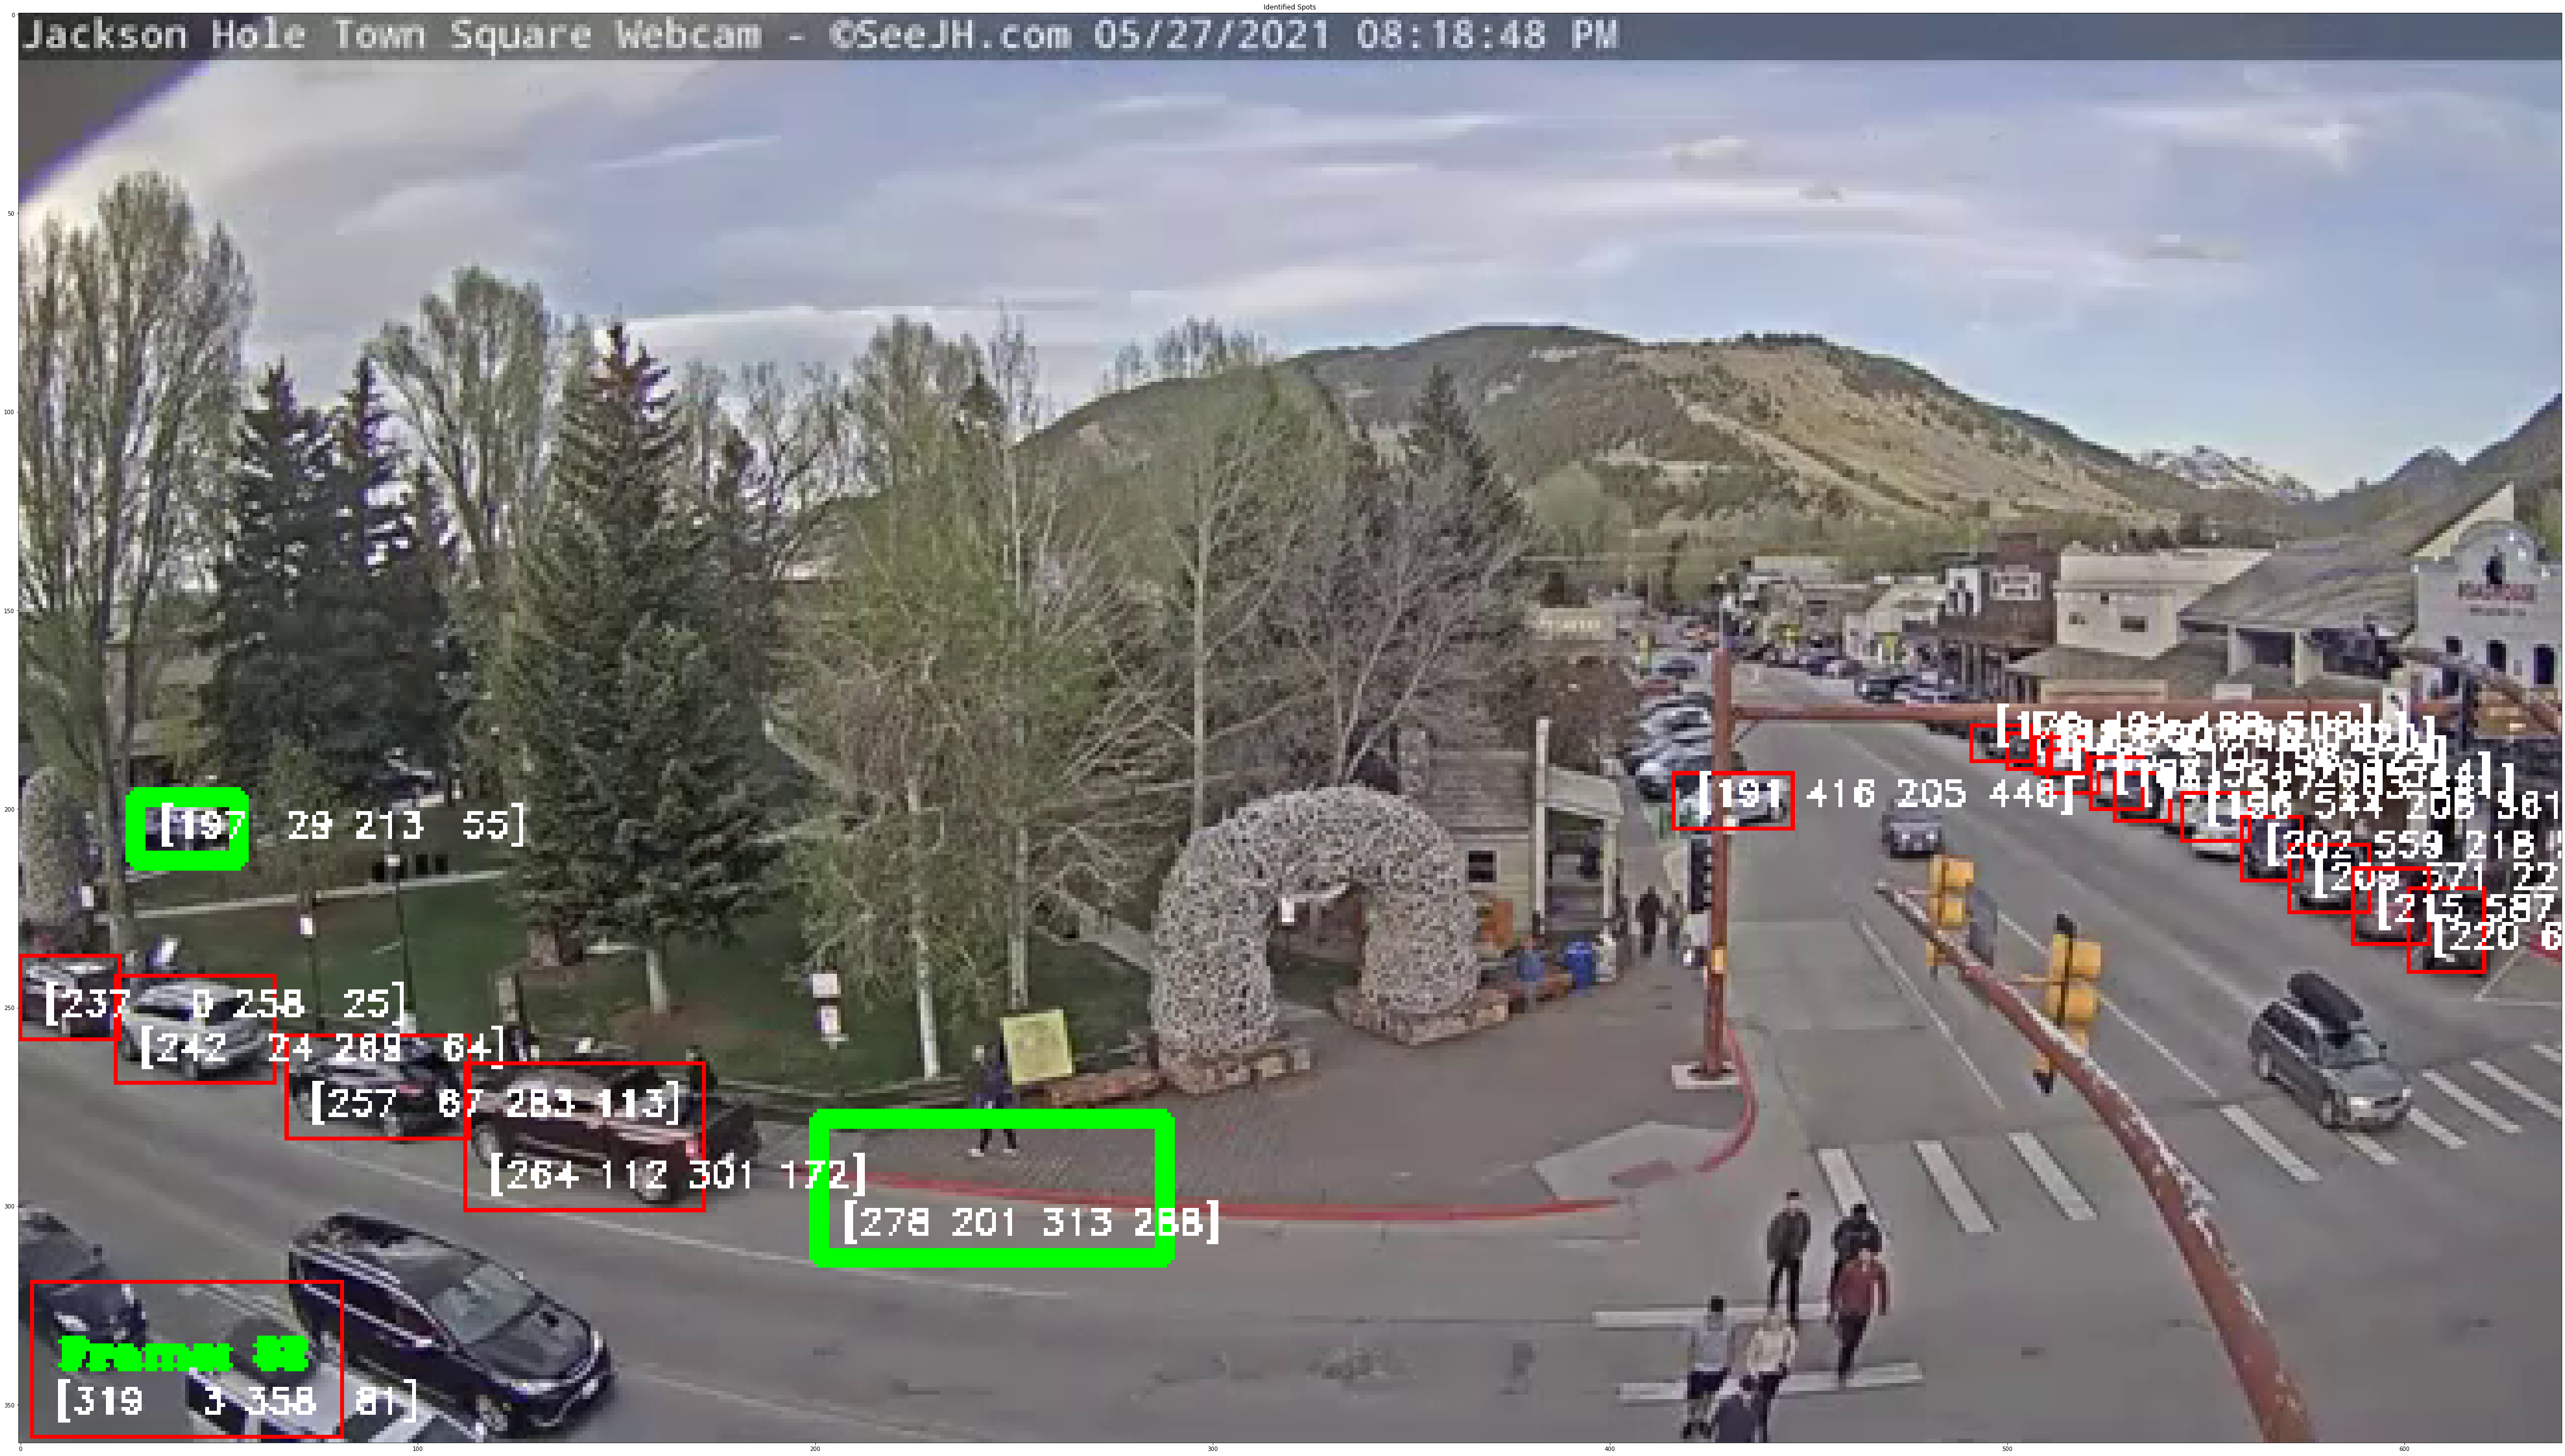

In [45]:
###### Load boxes from file if they exist
boundingBoxFile = os.path.join(ROOT_DIR,r'data\processed\demo_parked_car_spots.csv')
box_video = os.path.join(ROOT_DIR,r"data\raw\all_day_box_train.mp4")
assert os.path.exists(box_video), "Make sure your video file path is correct"

if os.path.exists(boundingBoxFile):
#if False:  #Force re-run
    parked_car_boxes = np.loadtxt(boundingBoxFile, delimiter=',')
    print("Loading existing bounding boxes")
else:
    #Learn where boxes are from movie, and save video with annotations
    #Sources is either VDIEO_SOURCE or try with tempFile
    parked_car_boxes = detectSpots(box_video, os.path.join(VIDEO_SAVE_DIR, "demo_box_processed.avi"), 75, 82)
    
    #One of those 'spots' is actually a car on the road, I'm going to remove it manually
    badSpot = np.where(parked_car_boxes == [319,   3, 358,  81])
    parked_car_boxes = np.delete(parked_car_boxes, badSpot[0][0], axis=0)

    #Save edited boxes to file for future use
    np.savetxt(boundingBoxFile, parked_car_boxes, delimiter=',')

In [19]:
cv2.destroyAllWindows()  #Close the video player


In [ ]:
# Run on VIDEO_SOURCE to use original file
demo_video=
vacant_spot_dict = countSpots(video_source = demo_video, parked_car_boxes=parked_car_boxes, video_save_file=VIDEO_SAVE_FILE,
          freeSpaceFrameCutOff=0, skipNFrames=1)